In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [21]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tabulate

UNNORMALIZE_FACTOR = 131  # MAX(HomeSpreadActual) - MIN(HomeSpreadActual)
UNNORMALIZE_FACTOR_PREDICT = 41

# REGRESSION
# Return X = testable features, Y = point spread
def spread_df_rgn(normalize=False, get_custom_date_range=False, substituted_spreads=None):
  data_df = pd.read_csv('combined_out.csv')

  real_cols = data_df.select_dtypes(include=['number']).columns

  if not get_custom_date_range:
    data_df = data_df.dropna(axis=0)

  if normalize:
    for col in real_cols:
      min_val = data_df[col].min()
      max_val = data_df[col].max()
      data_df[col] = (data_df[col] - min_val) / (max_val - min_val)

  if get_custom_date_range:
    data_df = data_df[(data_df['Date'] >= '2024-04-01') & (data_df['Date'] <= '2024-04-07')]
    data_df['HomeSpread'] = substituted_spreads
    data_df['HomeSpreadCorrectDirection'] = data_df['HomeSpreadActual'] > data_df['HomeSpread']
    data_df['HomeSpreadCorrectDirection'] = data_df['HomeSpreadCorrectDirection'].astype(int)
  
  data_df = data_df.drop('AwayTeam', axis=1)\
                   .drop('HomeTeam', axis=1)\
                   .drop('Date', axis=1)
  
  data_np = data_df.to_numpy()
  data_np = data_np[:, 5:]

  data_np = data_np.astype(float)

  return data_np[:, 1:-1], data_np[:, :1]

# CLASSIFICATION
# Return X = testable features, Y = correct point spread direction
def spread_df_cls(normalize=False, get_custom_date_range=False, substituted_spreads=None):
  data_df = pd.read_csv('combined_out.csv')

  real_cols = data_df.select_dtypes(include=['number']).columns

  if not get_custom_date_range:
    data_df = data_df.dropna(axis=0)

  if normalize:
    for col in real_cols:
      min_val = data_df[col].min()
      max_val = data_df[col].max()
      data_df[col] = (data_df[col] - min_val) / (max_val - min_val)

  if get_custom_date_range:
    data_df = data_df[(data_df['Date'] >= '2024-04-01') & (data_df['Date'] <= '2024-04-07')]
    data_df['HomeSpread'] = substituted_spreads
    data_df['HomeSpreadCorrectDirection'] = data_df['HomeSpreadActual'] > data_df['HomeSpread']
    data_df['HomeSpreadCorrectDirection'] = data_df['HomeSpreadCorrectDirection'].astype(int)

  data_df = data_df.drop('AwayTeam', axis=1)\
                   .drop('HomeTeam', axis=1)\
                   .drop('Date', axis=1)
  
  data_np = data_df.to_numpy()
  data_np = data_np[:, 5:]

  data_np = data_np.astype(float)

  return data_np[:, 1:-1], data_np[:, -1:]

In [22]:
X, y = spread_df_cls()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [23]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5123674911660777

Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.52      0.52      1999
         1.0       0.51      0.51      0.51      1963

    accuracy                           0.51      3962
   macro avg       0.51      0.51      0.51      3962
weighted avg       0.51      0.51      0.51      3962



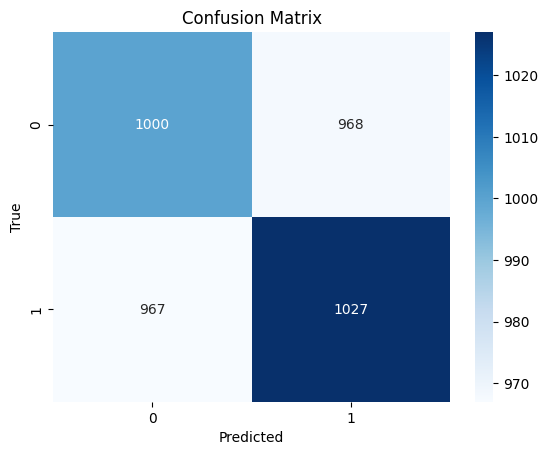

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

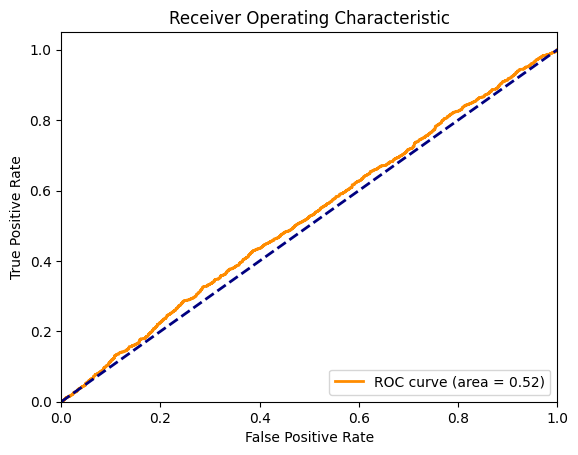

In [14]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [24]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9]
}

# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False),
    param_grid=param_grid,
    cv=5, # Number of folds in cross-validation
    scoring='accuracy', # Metric for scoring
    verbose=1, # Higher means more messages
    n_jobs=-1 # Number of jobs to run in parallel
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Review the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best score: 0.5414957399810666
